In [1]:
# import system libraries
import os
import warnings
from pathlib import Path
import shutil

In [15]:
# import basic libraries
import numpy as np
import pandas as pd

In [18]:
print(numpy.__version__)

1.23.1


In [19]:
# required for supressing warnings of Tensorflow
import warnings

# Suppress TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # suppress info, warnings but lets out errors
warnings.filterwarnings("ignore", category=UserWarning, module='tensorflow')

In [20]:
# importing the actual libraries
import tensorflow as tf
from tensorflow import keras

In [21]:
tf.__version__

'2.14.0'

In [22]:
!ls

Capstone1Screenshots		    notebook_Training.ipynb
README.md			    requirements.txt
Untitled.ipynb			    temp_dataset
coppersmith-barbet-prerna-jain.jpg  train.py
dataset				    xception_v_final_19_0.959.h5
notebook_EDA.ipynb		    xception_v_script_17_0.956.h5


## Convert Keras to TF-Lite

In [36]:
#load the best model generated by the script
model = keras.models.load_model('xception_v_script_17_0.956.h5')

In [37]:
#convert to TF-Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)

In [38]:
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpmulnq9za/assets


INFO:tensorflow:Assets written to: /tmp/tmpmulnq9za/assets


In [39]:
 # save the converted model to a file
with open('xception_v_script_17_0.956.tflite', 'wb') as f_out:
    f_out.write(tflite_model)
f_out.close()

In [40]:
!ls -lh

total 251M
drwxr-xr-x 2 sidd4ml sidd4ml 4.0K Jan 14 05:56 Capstone1Screenshots
-rw-r--r-- 1 sidd4ml sidd4ml  15K Jan 14 05:57 README.md
-rw-r--r-- 1 sidd4ml sidd4ml 8.0K Jan 14 12:20 Untitled.ipynb
-rw-r--r-- 1 sidd4ml sidd4ml 484K Nov 15  2019 coppersmith-barbet-prerna-jain.jpg
drwxr-xr-x 6 sidd4ml sidd4ml 4.0K Jan 13 21:53 dataset
-rw-r--r-- 1 sidd4ml sidd4ml 5.3M Jan 13 13:34 notebook_EDA.ipynb
-rw-r--r-- 1 sidd4ml sidd4ml 644K Jan 14 12:20 notebook_Training.ipynb
-rw-r--r-- 1 sidd4ml sidd4ml   78 Jan 13 22:55 requirements.txt
drwxr-xr-x 3 sidd4ml sidd4ml 4.0K Jan 13 13:33 temp_dataset
-rw-r--r-- 1 sidd4ml sidd4ml 3.1K Jan 14 04:16 train.py
-rw-r--r-- 1 sidd4ml sidd4ml  83M Jan 13 23:56 xception_v_final_19_0.959.h5
-rw-r--r-- 1 sidd4ml sidd4ml  83M Jan 14 05:31 xception_v_script_17_0.956.h5
-rw-r--r-- 1 sidd4ml sidd4ml  81M Jan 14 12:20 xception_v_script_17_0.956.tflite


### Getting a bird image from one of the 25 classes that is not in the dataset and visualize it to tally with subsequent prediction

In [57]:
# we select an image not in the dataset
url = 'https://media.gettyimages.com/id/135775020/photo/a-crow-quenches-its-thirst-with-water-leaking-from-a-pipe-at-the-zoo-in-lahore-24-june-2005.jpg?s=612x612&w=gi&k=20&c=gnQtw8CRKq0CYwCBiV5F8hPKHu3aFz978Vf9uG9DU4w='

In [58]:
from io import BytesIO
from urllib import request
from PIL import Image

In [59]:
def download_image(url):
    with request.urlopen(url) as resp:
        buffer = resp.read()
    stream = BytesIO(buffer)
    img = Image.open(stream)
    return img

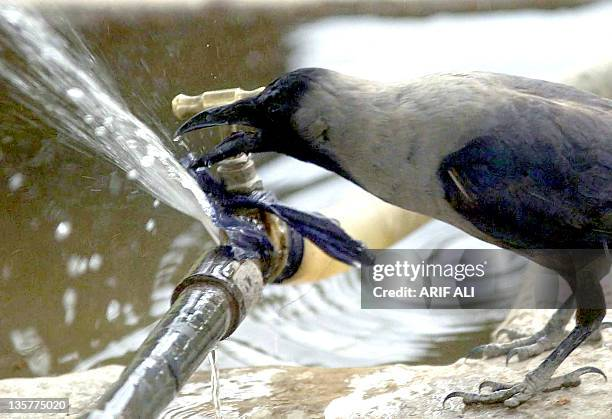

In [61]:
from tensorflow.keras.preprocessing.image import load_img
img = download_image(url)
img

So we see it is the image of a House Crow we need to predict the name of.

## Predicting the image class with the tflite model

In [8]:
# install keras-image-helper
!pip install keras-image-helper

In [12]:
# install tflite_runtime
!pip install --no-deps --extra-index-url https://google-coral.github.io/py-repo/tflite_runtime

Looking in indexes: https://pypi.org/simple, https://google-coral.github.io/py-repo/


In [41]:
#import from tflite_runtime tflite
import tflite_runtime.interpreter as tflite
from keras_image_helper import create_preprocessor

In [42]:
# loading the tflite model
interpreter = tflite.Interpreter(model_path='xception_v_script_17_0.956.tflite')
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]['index']
output_index = interpreter.get_output_details()[0]['index']

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [45]:
# create preprocessor
preprocessor = create_preprocessor('xception', target_size=(299, 299))

In [62]:
# feed image to preprocessor
url = url
X = preprocessor.from_url(url)

In [63]:
# Now applying this model to this image
interpreter.set_tensor(input_index,  X.astype(np.float32))
interpreter.invoke()
preds = interpreter.get_tensor(output_index)

In [64]:
# my image class list as derieved from my training notebook
bird_classes= ['Asian Green Bee-Eater',
 'Brown-Headed Barbet',
 'Cattle Egret',
 'Common Kingfisher',
 'Common Myna',
 'Common Rosefinch',
 'Common Tailorbird',
 'Coppersmith Barbet',
 'Forest Wagtail',
 'Gray Wagtail',
 'Hoopoe',
 'House Crow',
 'Indian Grey Hornbill',
 'Indian Peacock',
 'Indian Pitta',
 'Indian Roller',
 'Jungle Babbler',
 'Northern Lapwing',
 'Red-Wattled Lapwing',
 'Ruddy Shelduck',
 'Rufous Treepie',
 'Sarus Crane',
 'White Wagtail',
 'White-Breasted Kingfisher',
 'White-Breasted Waterhen']

In [65]:
# checking the predictions
prediction_probabilites = dict(zip(bird_classes, preds[0]))

In [67]:
# Get the class with the highest probability
max_class = max(prediction_probabilites, key=prediction_probabilites.get)

# Get the corresponding probability
max_probability = prediction_probabilites[max_class]

print(f"The bird appears to be a '{max_class}' with a probability of {max_probability}")

The bird appears to be a 'House Crow' with a probability of 9.61806583404541


#### And it is indeed a House Crow

## Thank You